# Computer Vision & Deep Learning - SEP Practical

## Exercise Sheet 5: Training a neural network

**Due on 21.12.2023, 10:00**

## Important notes

- Email: Frequently check your email address registered for Moodle. All notifications regarding the course will be sent via Moodle.
- Moodle: Please use the Moodle platform and post your questions to the forum. They will be answered by us or your fellow students.
-  Submission: Put your code and potentially other materials inside a single ZIP file. If you use jupyter notebooks, please always create a PDF file and include it in your ZIP file. The final submission should therefore be a **single zip** file with a **PDF of your code** and the **original code** inside. The ZIP file should contain your surname and your matriculation number (Surname-MatriculationNumber.zip). Submissions that fail to follow the naming convention will not be graded!

In [1]:
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt
from torch.optim import Adam
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm # Not necessary, but gives a nice progress bar

# 1 Preparation (4)

## 1.1 Creating dataset (2)

In the standard training paradigm, we employ [stochastic gradient descent (SGD)](https://en.wikipedia.org/wiki/Stochastic_gradient_descent). This involves selecting a constant number of samples from the dataset and performing backpropagation on this subset during each iteration. To start with, we implement a MNIST dataset using `torch.utils.data.Dataset`.

Create a dataset which inherits from `torch.utils.data.Dataset`, and process the MNIST dataset `torch.datasets.MNIST`. The input to the `__init__` should be either `train` or `validation`, which determines which samples we choose. [Flatten](https://pytorch.org/docs/stable/generated/torch.flatten.html) the *height* and *width* dimension and normalize the values to a range of $[-1,1]$ for processing. 

The `__getitem__` function should return the corresponding image and label pair. Return everything in `Torch.Tensor` format.

In [2]:
def convert_to_numpy(data):
    data_tensor = data.data
    out = (data_tensor.float() / 127.5 - 1.).numpy().reshape(data_tensor.shape[0],-1)
    return out, data.targets.numpy().astype(int)

class MnistVectors(torch.utils.data.Dataset):
    '''A Pytorch Dataset, which does the same data preparation as was done in
    the PCA exercise.'''

    def __init__(self, split='train'):
        super().__init__()
        
        mnist = datasets.MNIST('../data',
                               train=split=='train',
                               download=True)

        self.mnist_vectors, self.labels = convert_to_numpy(mnist)

            
    def __getitem__(self, idx):
        '''Implements the ``[idx]`` method. Here we convert the numpy data to
        torch tensors.
        '''

        mvec = torch.tensor(self.mnist_vectors[idx]).float()
        label = torch.tensor(self.labels[idx]).long()

        return mvec, label
    
    def __len__(self):
        return len(self.labels)


## 1.2 Creating dataloader (2)

In PyTorch, a `torch.utils.data.DataLoader` is a class that provides efficient and parallelized loading of data for training a neural network. It wraps a dataset and provides an iterable over batches of data.

Create the MNIST train and val datasets, and their corresponding dataloader. They should take a batch size of 32. Do you think it's a good idea to turn `shuffle` on for the validation dataloader? Provide reasoning for this.

Test your dataloader output by outputting a sample by `next(iter(your_dataloader))`. Make sure that you are outputting the right batch size of samples.

In [3]:
TrainData = MnistVectors()
TestData = MnistVectors('test')
# Dataloaders allow us to load the data in batches. This allows us a better
# estimate of the parameter updates when doing backprop.
# We need two Dataloaders so that we can train on the train data split
# and evaluate on the test datasplit.
Dl = DataLoader(TrainData, batch_size=32, shuffle=True)
testDl = DataLoader(TestData, batch_size=32, shuffle=False)

print(next(iter(Dl))[0].shape)


torch.Size([32, 784])


# 2 Training a MLP (12)

## 2.1 Defining a MLP (4)

In this section, we formulate the architecture of the neural network. The MLP should consists of 5 MLP layers, which you can implement using the `nn.Linear` function. The first layer have a input channel dimension of $28*28=784$ and all of the intermediate channel dimensions are $100$. Make sure to define the last layer in a way that we get an tensor of size $[10,]$ so that we can do the classification. The activation function that we use in this exercise is `torch.nn.ReLU()`, and make sure that it is present after each MLP layer except for the last one.

The forward function should go through each of the layers consecutively. Do not forget the activation functions!

Also print out the number of parameters of this model.

In [4]:
class MultilayerPerceptron(nn.Module):
    
    def __init__(self, size_hidden=100, size_out=10):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=784,
                             out_features=100)
        self.fc2 = nn.Linear(in_features=100,
                             out_features=100)
        self.fc3 = nn.Linear(in_features=100,
                             out_features=100)
        self.fc4 = nn.Linear(in_features=100,
                             out_features=100)
        self.out_layer = nn.Linear(in_features=100,
                             out_features=10) 
        
        self.relu = torch.nn.ReLU()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.out_layer(out)
        return out
    
MLP = MultilayerPerceptron()
print(sum([_.numel() for _ in MLP.parameters()]))

109810


## 2.2 Defining the eval functions (3)

Implement the following two functions, which we will use for evaluation.

In [5]:
def batch_accuracy(prediction, label):
    """returns the accuracy of the prediction for the given label

    Args:
        prediction (torch.Tensor): the prediction of the model
        label (torch.Tensor): the groundtruth label

    Returns:
        the accuracy in percent, dtype=float
    """
    trues = torch.eq(prediction,label).float()
    return trues.sum() / trues.shape[0] * 100

def class_label(prediction):
    """returns the class label which outputs the maximum value for the given prediction

    Args:
        prediction (torch.Tensor): the prediction of the model

    Returns:
        the class label, dtype=int
    """
    return torch.argmax(prediction,dim=-1)

# 2.3 Training and evaluation of the network (4)

We finally start training here! By utliizing the dataloader and neural network we defined, we can perform backpropagation and weight updates with just a few lines of code. Also evaluate after each epoch. (One epoch is when you iterate through a dataset one time)

Print out the evaluation results per epoch and plot the losses.

Epoch:  33%|███▎      | 1/3 [00:01<00:03,  1.83s/it]

Validation Accuracy: 89.63658142089844%


Epoch:  67%|██████▋   | 2/3 [00:04<00:02,  2.18s/it]

Validation Accuracy: 92.2723617553711%


Epoch: 100%|██████████| 3/3 [00:05<00:00,  1.99s/it]


Validation Accuracy: 93.5503158569336%


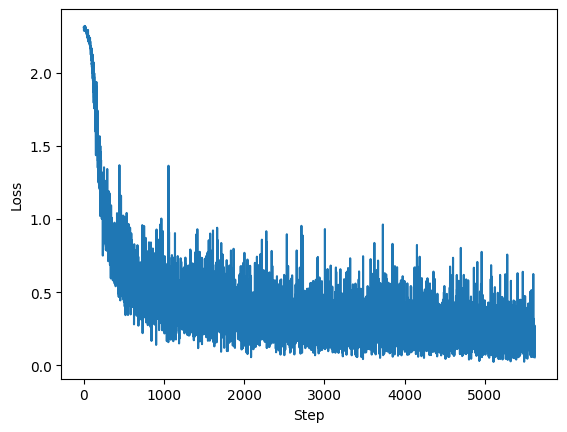

In [6]:
# We don't use GPU for now, but you can try to use it if you have one
# available. This will speed up training a lot, and it is very easy to
# use in pytorch
use_gpu = False
    
# Here we instantiate our model. The weights of the model are automatically
# initialized by pytorch
P = MultilayerPerceptron()

# Use the Adam optimizer with learning rate 1e-4 and otherwise default
# values. Also record the loss for each step in the list losses.
optimizer = Adam(P.parameters(),lr=1.e-4)
losses = []

# Use the Cross Entropy loss from pytorch. Make sure your MultilayerPerceptron does
# not use any activation function on the output layer! (Do you know why?)
criterion = torch.nn.CrossEntropyLoss()

if use_gpu:
    P.cuda()
    criterion.cuda()

for epoch in tqdm(range(3), desc='Epoch'):
    for step, [example, label] in enumerate(tqdm(Dl, desc='Batch')):
        if use_gpu:
            example = example.cuda()
            label = label.cuda()

        # The optimizer knows about all model parameters. These in turn
        # store their own gradients. When calling loss.backward() the newly
        # computed gradients are added on top of the existing ones. Thus
        # at before calculating new gradients we need to clear the old ones
        # using ther zero_grad() method.
        optimizer.zero_grad()

        # Here we compute the forward pass of the model. This means we
        # compute the output of the model for the given input example.
        prediction = P(example)

        # Now we compute the loss between the prediction and the label
        # using the criterion we defined above.
        loss = criterion(prediction, label)

        # Here pytorch applies backpropagation for us completely
        # automatically!!! That is quite awesome!
        loss.backward()
        losses.append(loss.cpu().detach().numpy())

        # The step method now adds the gradients onto the model parameters
        # as specified by the optimizer and the learning rate.
        optimizer.step()

    # Now validate on the whole test set
    accuracies = []
    for idx, [test_ex, test_l] in enumerate(tqdm(testDl, desc='Test')):
        if use_gpu:
            test_ex = test_ex.cuda()
            test_l = test_l.cuda()

        with torch.no_grad():
            prediction = P(test_ex)

        acc = batch_accuracy(class_label(prediction),test_l)

        accuracies.append(acc.cpu().numpy())
        # Using your batch_accuracy function, also print the mean accuracy
        # over the whole test split of the data.

    print('Validation Accuracy: {}%'.format(np.mean(accuracies)))

plt.plot(losses)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()


## 2.4 Visualize the predictions (1)

Make a plot containing 16 images from the test set. (Recall that you may use `next(iter())` to acccess the samples from a dataloader) Plot each image with
its predicted label. Use the class_label function to get the predicted
label from the model output.
You can use the `plt.subplot` function to plot multiple images in one plot.

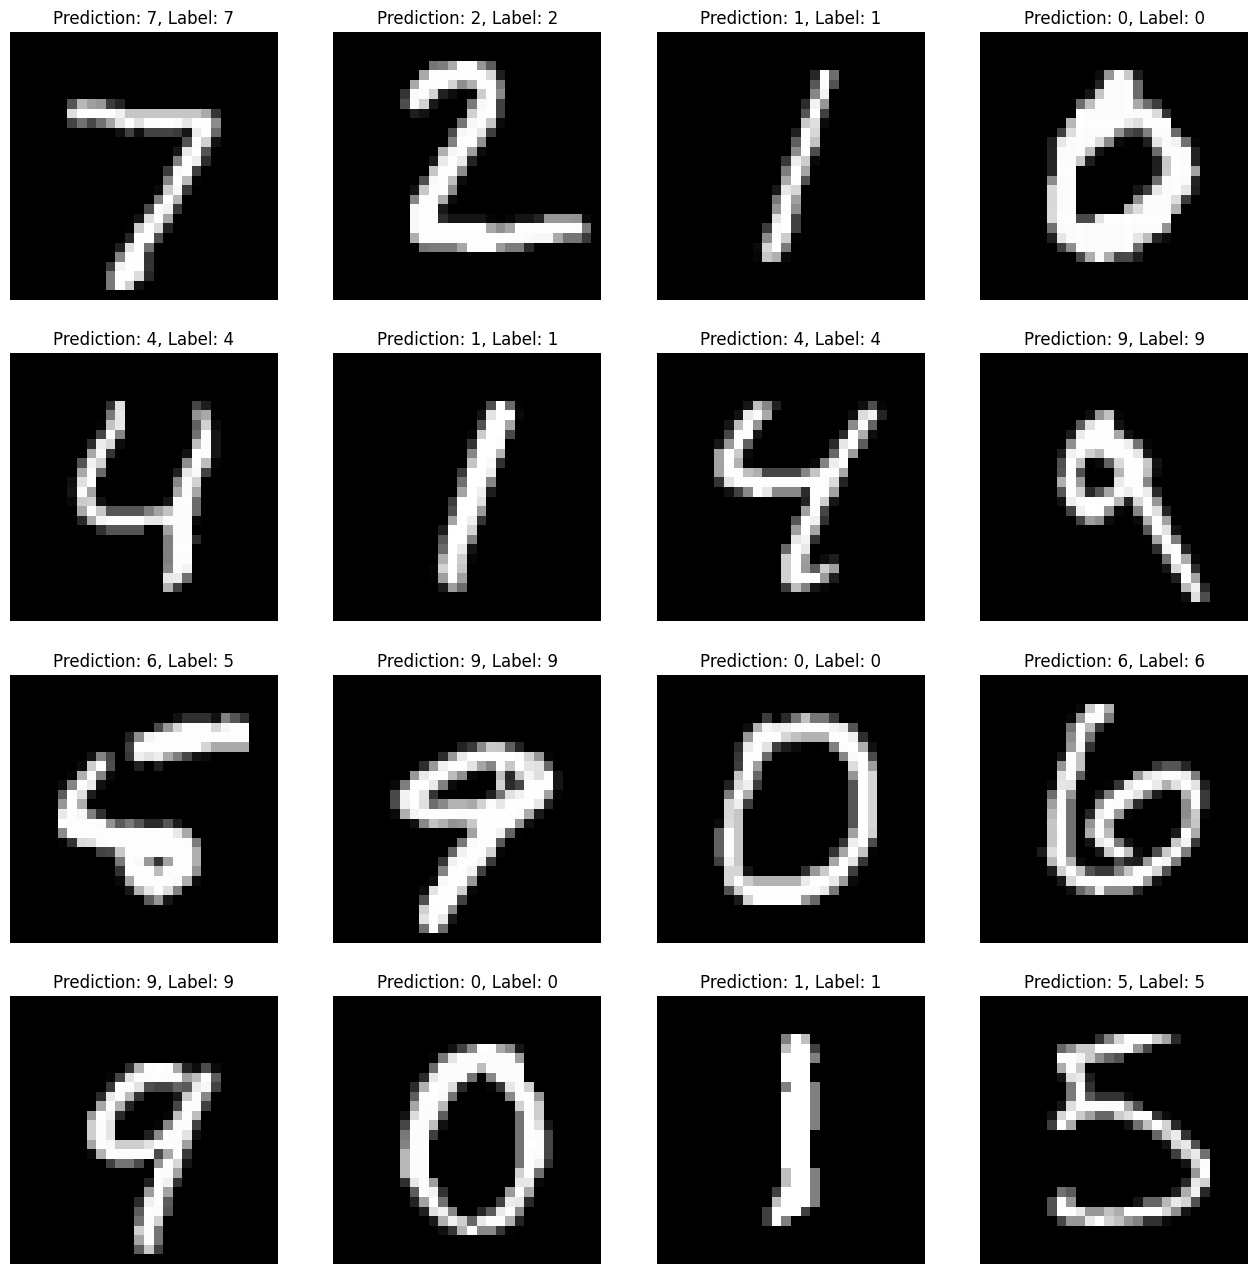

In [7]:
# Visualize a batch and its predictions
example, label = next(iter(testDl))
with torch.no_grad():
    prediction = P(example)
    pred_label = class_label(prediction)
    plt.figure(figsize=(16, 16))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(example[i].cpu().numpy().reshape(28, 28), cmap='gray')
        plt.title(f'Prediction: {pred_label[i]}, Label: {label[i]}')
        plt.axis('off')

# 3 Training a Convolutional Neural Network (8)

# 3.1 Data loading (2)
In this exercise we will implement a convolutional neural network (CNN) for
image classification. We will use the MNIST dataset again, but this time we
will use the images directly instead of the flattened representation.

In [8]:
def convert_to_numpy(data):
    data_tensor = data.data
    out = (data_tensor.float() / 127.5 - 1.).numpy()
    out = np.expand_dims(out,1)
    return out, data.targets.numpy().astype(int)

class MnistVectorsHW(torch.utils.data.Dataset):
    '''A Pytorch Dataset, which does the same data preparation as was done in
    the PCA exercise.'''

    def __init__(self, split='train'):
        super().__init__()
        
        mnist = datasets.MNIST('../data',
                               train=split=='train',
                               download=True)

        self.mnist_vectors, self.labels = convert_to_numpy(mnist)

            
    def __getitem__(self, idx):
        '''Implements the ``[idx]`` method. Here we convert the numpy data to
        torch tensors.
        '''

        mvec = torch.tensor(self.mnist_vectors[idx]).float()
        label = torch.tensor(self.labels[idx]).long()

        return mvec, label
    
    def __len__(self):
        return len(self.labels)

In [9]:
TrainData = MnistVectorsHW()
TestData = MnistVectorsHW('test')
# Dataloaders allow us to load the data in batches. This allows us a better
# estimate of the parameter updates when doing backprop.
# We need two Dataloaders so that we can train on the train data split
# and evaluate on the test datasplit.
Dl = DataLoader(TrainData, batch_size=32, shuffle=True)
testDl = DataLoader(TestData, batch_size=32, shuffle=False)


## 3.2 Defining a CNN (2)

Here, we define a structure similar to [LeNet](https://en.wikipedia.org/wiki/LeNet). It comprises of two conv layers, two max poolings layers and 3 fc layers, but instead of `torch.nn.Sigmoid()`, we use ReLU as activation function. We define the layers for you, but you need to chain them in the forward function. Make sure to use the activation function after each `conv+pool` and `fc` layer except for the last fc layer.

Please refer to the link for network structure if you find any problems chaining them in the forward function.

In [10]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self, normalization=False):
        super().__init__()                                                                                              #   spatial dimension
        self.normalization = normalization                                                                              #   input   output
        # convolution block
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5, 5), padding=2, stride=1)               #   28x28  ->  24x24
        self.pool = nn.MaxPool2d(kernel_size=2)                                                            #   24x24  ->  12x12
        self.conv2 = nn.Conv2d(6, 16, kernel_size=(5, 5), padding=0, stride=1)                                    #   12x12  ->  8x8
        self.pool2 = nn.MaxPool2d(kernel_size=2)                                                           #   8x8 -> 4x4
        # fully connected block
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        # activation function
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        # Implement the forward pass and use the layers in the order they were defined in the init method.
        # Use Relu as the activation function
        # Hint: you can use tensor.view() to reshape a tensor in pytorch
        x = self.conv1(x)
        x = self.pool(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.relu(x)

        x = x.view(x.shape[0],-1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x
    
cnn = ConvolutionalNetwork()
print(sum([_.numel() for _ in cnn.parameters()]))

61706


## 4.3 Training a CNN (3)

Write a code like before, where you train a CNN for 3 epochs, evaluate the model after each epoch and keep track of the losses.

Epoch:  33%|███▎      | 1/3 [00:11<00:22, 11.04s/it]

Validation Accuracy: 93.99960327148438%


Epoch:  67%|██████▋   | 2/3 [00:21<00:10, 10.82s/it]

Validation Accuracy: 96.02635955810547%


Epoch: 100%|██████████| 3/3 [00:32<00:00, 10.83s/it]

Validation Accuracy: 96.93490600585938%


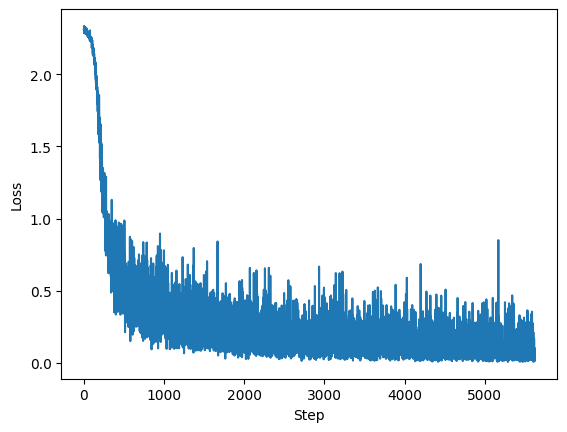

In [11]:
# We don't use GPU for now, but you can try to use it if you have one
# available. This will speed up training a lot, and it is very easy to
# use in pytorch
use_gpu = False
    
# Here we instantiate our model. The weights of the model are automatically
# initialized by pytorch
P = ConvolutionalNetwork()

# Use the Adam optimizer with learning rate 1e-4 and otherwise default
# values. Also record the loss for each step in the list losses.
optimizer = Adam(P.parameters(),lr=1.e-4)
losses = []

# Use the Cross Entropy loss from pytorch. Make sure your MultilayerPerceptron does
# not use any activation function on the output layer! (Do you know why?)
criterion = torch.nn.CrossEntropyLoss()

if use_gpu:
    P.cuda()
    criterion.cuda()

for epoch in tqdm(range(3), desc='Epoch'):
    for step, [example, label] in enumerate(tqdm(Dl, desc='Batch')):
        if use_gpu:
            example = example.cuda()
            label = label.cuda()

        # The optimizer knows about all model parameters. These in turn
        # store their own gradients. When calling loss.backward() the newly
        # computed gradients are added on top of the existing ones. Thus
        # at before calculating new gradients we need to clear the old ones
        # using ther zero_grad() method.
        optimizer.zero_grad()

        # Here we compute the forward pass of the model. This means we
        # compute the output of the model for the given input example.
        prediction = P(example)

        # Now we compute the loss between the prediction and the label
        # using the criterion we defined above.
        loss = criterion(prediction, label)

        # Here pytorch applies backpropagation for us completely
        # automatically!!! That is quite awesome!
        loss.backward()
        losses.append(loss.cpu().detach().numpy())

        # The step method now adds the gradients onto the model parameters
        # as specified by the optimizer and the learning rate.
        optimizer.step()

    # Now validate on the whole test set
    accuracies = []
    for idx, [test_ex, test_l] in enumerate(tqdm(testDl, desc='Test')):
        if use_gpu:
            test_ex = test_ex.cuda()
            test_l = test_l.cuda()

        with torch.no_grad():
            prediction = P(test_ex)

        acc = batch_accuracy(class_label(prediction),test_l)

        accuracies.append(acc.cpu().numpy())
        # Using your batch_accuracy function, also print the mean accuracy
        # over the whole test split of the data.

    print('Validation Accuracy: {}%'.format(np.mean(accuracies)))

plt.plot(losses)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()


## 4.4. Visualize the predictions (1)

Make a plot containing 16 images from the test set. (Recall that you may use `next(iter())` to acccess the samples from a dataloader) Plot each image with
its predicted label. Use the class_label function to get the predicted
label from the model output.
You can use the `plt.subplot` function to plot multiple images in one plot.

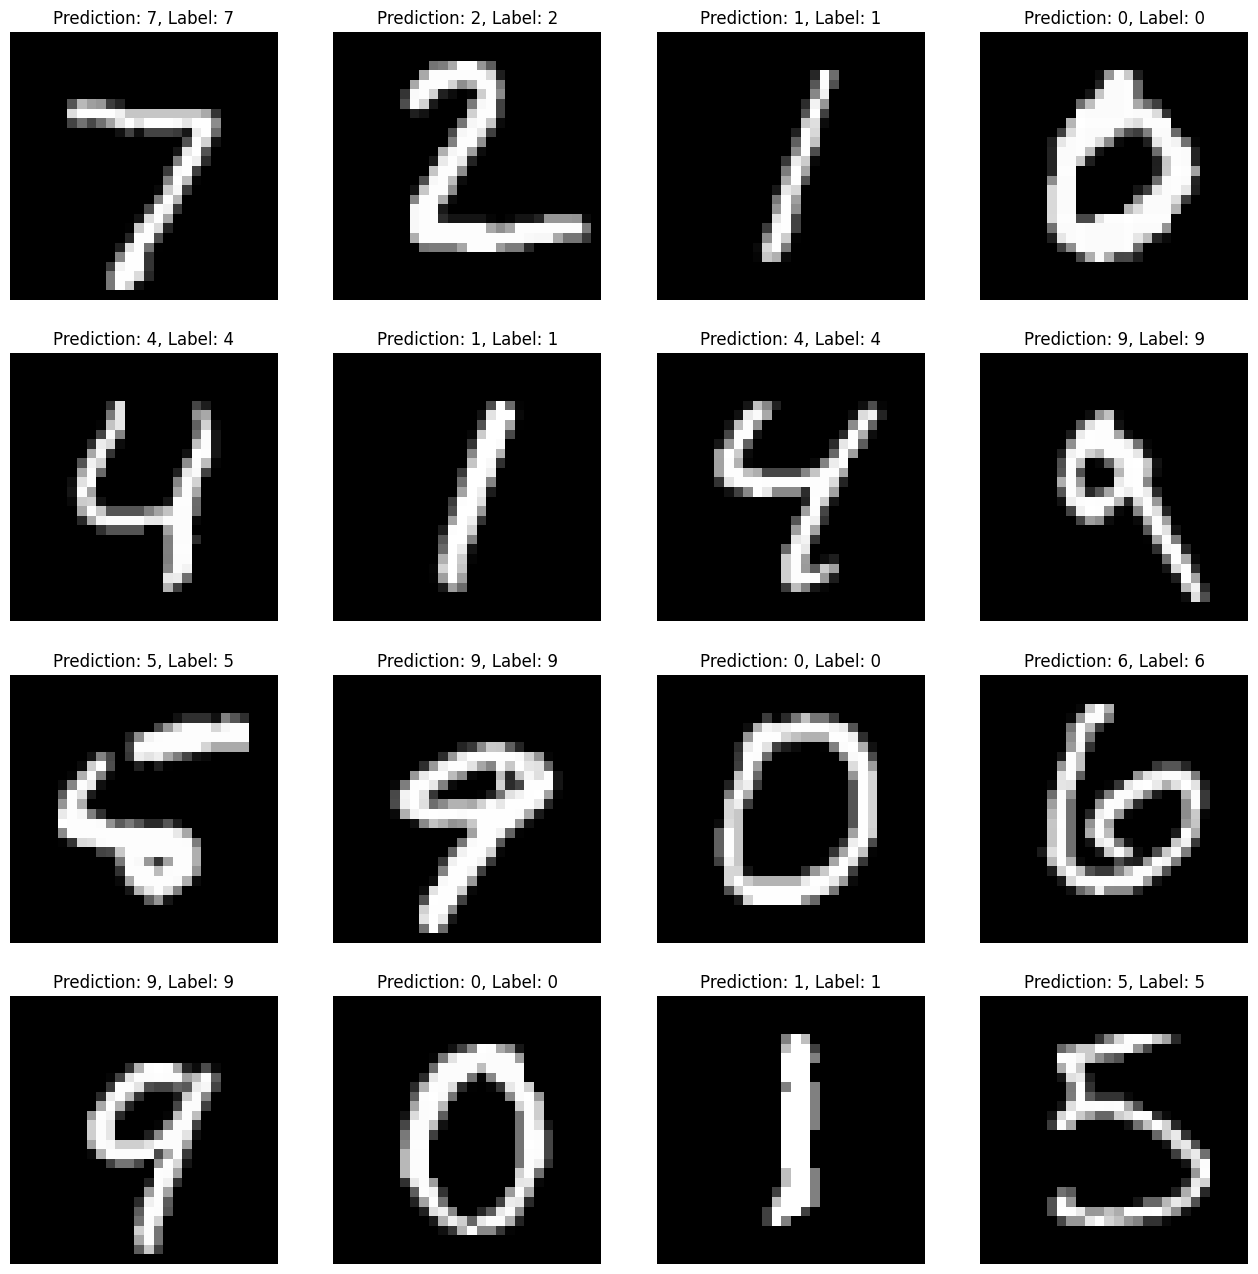

In [12]:
# Visualize a batch and its predictions
example, label = next(iter(testDl))
with torch.no_grad():
    prediction = P(example)
    pred_label = class_label(prediction)
    plt.figure(figsize=(16, 16))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(example[i].cpu().numpy().reshape(28, 28), cmap='gray')
        plt.title(f'Prediction: {pred_label[i]}, Label: {label[i]}')
        plt.axis('off')